# Sentiment Analysis of Tweets - Canada 2019 Election

### Description

**Sentiment Analysis** is a branch of Natural Language Processing (NLP) that allows us to determine algorithmically whether a statement or document is “positive” or “negative”.

Sentiment analysis is a technology of increasing importance in the modern society as it allows individuals and organizations to detect trends in public opinion by analyzing social media content. Keeping abreast of socio-political developments is especially important during periods of policy shifts such as election years, when both electoral candidates and companies can benefit from sentiment analysis by making appropriate changes to their campaigning and business strategies respectively.

The purpose of this assignment is to compute the sentiment of text information - in our case, tweets posted in 2019 Canadian elections - and answer the research question: ***“What can public opinion on Twitter tell us about the Canadian political landscape in 2019?”*** The goal is to essentially use sentiment analysis on Twitter data to get insight into the 2019 Canadian elections.

### Data 

Two sets of data are used for this assignment. **The generic_tweets.txt** file contains tweets that have had their sentiments already analyzed and recorded as binary values 0 (negative) and 4 (positive). You can find the dataset  [here](https://drive.google.com/file/d/1op_609F0g6MLjyL3P8a7j3_ZYvfSWTlP/view?usp=sharing).
Each line is a single tweet, which may contain multiple sentences despite their brevity. The comma-separated fields of each line are:

    0    class    the polarity of each tweet (0 = negative emotion, 4 = positive emotion)
    1    id       the id of the tweet (e.g. 2087)
    2    date     the date of the tweet (e.g. Sat May 16 23:58:44 UTC 2009)
    3    query    the query (e.g. lyx). If there is no query, then this value is NO_QUERY.
    4    user     the user that tweeted (e.g. robotickilldozr)
    5    text     the text of the tweet (e.g. Lyx is cool)
    
The second data set, **Canadian_elections_2019.csv**, contains a list of tweets regarding the 2019 Canadian elections. You can find the dataset [here](https://drive.google.com/file/d/1r9-OoRWRUxSGd3luf7CrnhsxDaGrQABJ/view?usp=sharing).
The fields of each line are:

    0    sentiment         can be “positive” or “negative”
    1    negative_reason   reason for negative tweets. Left blank for positive tweets.
    2    text              the text of the tweet
    
Both datasets have been collected directly from the web, so they may contain html tags, hashtags, and user tags.

For data cleaning, we will be removing stopwords from the tweets. I have made a list of stopwords which you can find [here](https://drive.google.com/file/d/1CMoEuQlSB18FmcKvAiGArzSmnqLF-O4C/view?usp=sharing).

### Evaluation 

The generic tweets dataset will be split randomly into training data (70%) and test data (30%). Then, we will prepare the data to try multiple classification algorithms like logistic regression, Naive Bayes, SVM, decision trees & ensembles, where each tweet is considered a single observation/example. In these models, the target variable is the sentiment value, which is either positive or negative. Funther, we will try two different types of features, Bag of words (word frequency) and TF-IDF.

We will train models on the training data and apply the model to the test data to obtain an accuracy value. Then, we are going to evaluate the same model with best performance on the 2019 Canadian elections data. We will choose the model that has the best performance and visualize the sentiment prediction results and the true sentiment for each of the 3 parties. Finally, we are going to discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.

# Import Data

In [1]:
#Import all the libraries that are needed
import pandas as pd
import numpy as np
import html
import nltk
from sklearn.metrics import confusion_matrix
from IPython.display import display
from time import time
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, StratifiedKFold,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import re

First we will import both datasets as well as stop words file and convert them into dataframe.

In [2]:
#import files & store as dataframe
df_canada_el = pd.read_csv("Canadian_elections_2019.csv", low_memory = False)

df_generic_twt = pd.read_csv("generic_tweets.txt",delimiter=',')

df_stop_words = pd.read_csv("stop_words.txt",delimiter=',')

#store stopwords as array
stop_words = df_stop_words.iloc[:,0]

df_generic_twt.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
df_canada_el.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


Now we check if there are any nulls in both the dataframes. 
We observe that there are 1126 nulls in negative_reason column in Election 2019 dataframe. This nulls belong to positive sentiments which makes sense.
We verify this by taking count of all positive tweets. Both the numbers match

In [4]:
print(df_canada_el.isnull().sum())
pos_sum = df_canada_el[df_canada_el['sentiment']=='positive']
print('positive tweet count = ',len(pos_sum)-1)
print('---------------------------')
print(df_generic_twt.isnull().sum())

sentiment             0
negative_reason    1126
text                  0
dtype: int64
positive tweet count =  1126
---------------------------
class    0
id       0
date     0
query    0
user     0
text     0
dtype: int64


# Data Cleaning 

The first step is to clean the data. For this, we extract text body from both generic & elections dataframe. 

We have made a single function named **preprocess_tweets()** which does all the cleaning using Python's **Regular Expression** module. Here are the steps that are performed in cleaning the tweets:
1. Remove all the URLs
2. Remove all the html characters, hashtags as well as punctuation marks.
3. Convert all the words to lowercase.

Secondly, we have designed function called **rem_stp_wrd()** which removes stop words from cleaned tweets. 

Finally, we print before & after results of both generic & election tweet for both the functions.

In [5]:
#extract text columns from both tweet files & stop word as a list
el =  df_canada_el.iloc[:,2]
gen =  df_generic_twt.iloc[:,5]
stop_words = list(stop_words)

#This function removes html chars, URLs & punctuation marks & does lowercasing.
def preprocess_tweets(tweets):
    processed_features = []
    for sentence in range(0, len(tweets)):
        processed_feature = re.sub('http\S+\s*', '',str(tweets[sentence]))          
        processed_feature = re.sub(r'\W', ' ', processed_feature ) #
        processed_feature = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
        processed_feature = re.sub(r'^b\s+', '', processed_feature)
        processed_feature = processed_feature.lower()
        processed_features.append(processed_feature)
    return processed_features

#This function removes stop words from cleaned tweets
def rem_stp_wrd(tweets):
    for s in range(0, len(tweets)):
        word_list = tweets[s].split()
        tweets[s] = ' '.join([i for i in word_list if i not in stop_words])
    return tweets

#Print before & after results 

print("Election tweet after cleaning --->")
election_twt_clean = preprocess_tweets(el)
print(election_twt_clean[1])
print('====================')
print("Election tweet after removing stop words --->")
election_twt_clean = rem_stp_wrd(election_twt_clean)
print(election_twt_clean[1])
print('====================')
print("Generic tweet after cleaning --->")
generic_twt_clean = preprocess_tweets(gen)
print(generic_twt_clean[0])
print('====================')
print("Election tweet after removing stop words --->")
generic_twt_clean = rem_stp_wrd(generic_twt_clean )
print(generic_twt_clean[0])

Election tweet after cleaning --->
allwomanspacewalk it real space_station etobicokenorth  cityofto  onpoli  cdnpoli  elxn43 
Election tweet after removing stop words --->
allwomanspacewalk real space_station etobicokenorth cityofto onpoli cdnpoli elxn43
Generic tweet after cleaning --->
 switchfoot   awww  that a bummer   you shoulda got david carr of third day to do it   d
Election tweet after removing stop words --->
switchfoot awww a bummer shoulda david carr third day


We see that the end result is clean tweet with relevant words.

# Exploratory analysis 

For exploratory analysis, we will see the trends in data for Election 2019 dataset. Firstly we have designed a function which determines the political party (Liberal, Conservative,NDP or None) of a tweet and have applied it to all the tweets in the 2019 Canadian elections dataset as well as Generic Tweets dataset. The function returns tweets for each party. This function also returns tokenized words in array from each datasets which we will use later for word-cloud.

In [6]:
#Store clean tweets in new separate arrays
process_election = election_twt_clean
process_generic = generic_twt_clean

#This function iterates over tweet in given set to find keywords related to each party & sorts them in respective bucket
def political_party(tweets):
    Liberal = []
    Conservative = []
    NDP = []
    NONE = []
    words = []
    for s in range(0, len(tweets)):
        word_list = tweets[s].split()
        words.append(word_list)
        if(any(x in word_list for x in ['liberal', 'trudeau', 'justintrudeau', 'ptlib','lpc'])):
            Liberal.append(tweets[s])
        elif(any(x in word_list for x in ['pttory', 'cpc', 'conservative','andrewscheer','andrew','scheer'])):
            Conservative.append(tweets[s])
        elif(any(x in word_list for x in ['ndp','ptndp','jagmeetsingh','jagmeet','singh'])):
            NDP.append(tweets[s])
        else:
            NONE.append(tweets[s])
    return Liberal,Conservative,NDP,NONE,words

#Passing generic & election dataset to get tweets for each party as well as tokenized words
Liberal_el,Conservative_el,NDP_el,NONE_el,words_el = political_party(process_election)

Liberal_gen,Conservative_gen,NDP_gen,NONE_gen,words_gen = political_party(process_generic)

Now we will see tweet counts for each party from election dataset as well as generic set

In [7]:
#2019 Election tweets data breakdown
print('2019 Election tweets data breakdown')
print('Total = ',len(election_twt_clean))
print('Liberal = ',len(Liberal_el))
print('Conservative = ',len(Conservative_el))
print('NDP = ',len(NDP_el))
print('NONE = ',len(NONE_el))      
print('Sum = ',len(Liberal_el)+len(Conservative_el)+len(NDP_el)+len(NONE_el))
print('=============================================================')
#generic tweets data breakdown
print('generic tweets data breakdown')
print('Total = ',len(generic_twt_clean))
print('Liberal = ',len(Liberal_gen))
print('Conservative = ',len(Conservative_gen))
print('NDP = ',len(NDP_gen))
print('NONE = ',len(NONE_gen))               
print('Sum = ',len(Liberal_gen)+len(Conservative_gen)+len(NDP_gen)+len(NONE_gen))      

2019 Election tweets data breakdown
Total =  2133
Liberal =  391
Conservative =  406
NDP =  116
NONE =  1220
Sum =  2133
generic tweets data breakdown
Total =  200000
Liberal =  5
Conservative =  72
NDP =  4
NONE =  199919
Sum =  200000


We can see that for 2019 Election tweet dataset, most of the tweets were not affiliated to any party (1220). From the rest, most of them were related to Conservative party (406). Liberal were the second most (391) while least number were for NDP(116).

For generic data, very small amount of tweets were political (81 out of 200000)

Now we will plot distribution for Canada Election 2019 tweets Dataset per party

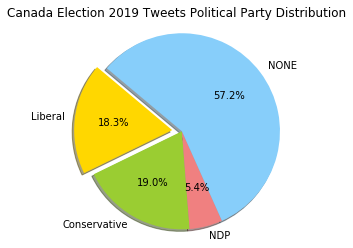

In [8]:
labels = 'Liberal', 'Conservative', 'NDP', 'NONE'
sizes = [len(Liberal_el), len(Conservative_el), len(NDP_el), len(NONE_el)]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title('Canada Election 2019 Tweets Political Party Distribution')
plt.show()

From the pie chart it is evident that **Conservative & Liberal parties got nearly equal share of tweets, while NDP got small share**. 

Now we will see some more Exploratory Data Analysis.

Here we will see most frequent words in both generic tweets & election tweets using wordcloud. For this we will use word array that we had gotten from political_party() function. In this array we have tokenized words from the tweet text body.

In [9]:
words_el_new = [item for sublist in words_el for item in sublist]
new_string_el = ' '.join(words_el_new)
words_gen_new = [item for sublist in words_gen for item in sublist]
new_string_gen = ' '.join(words_gen_new)

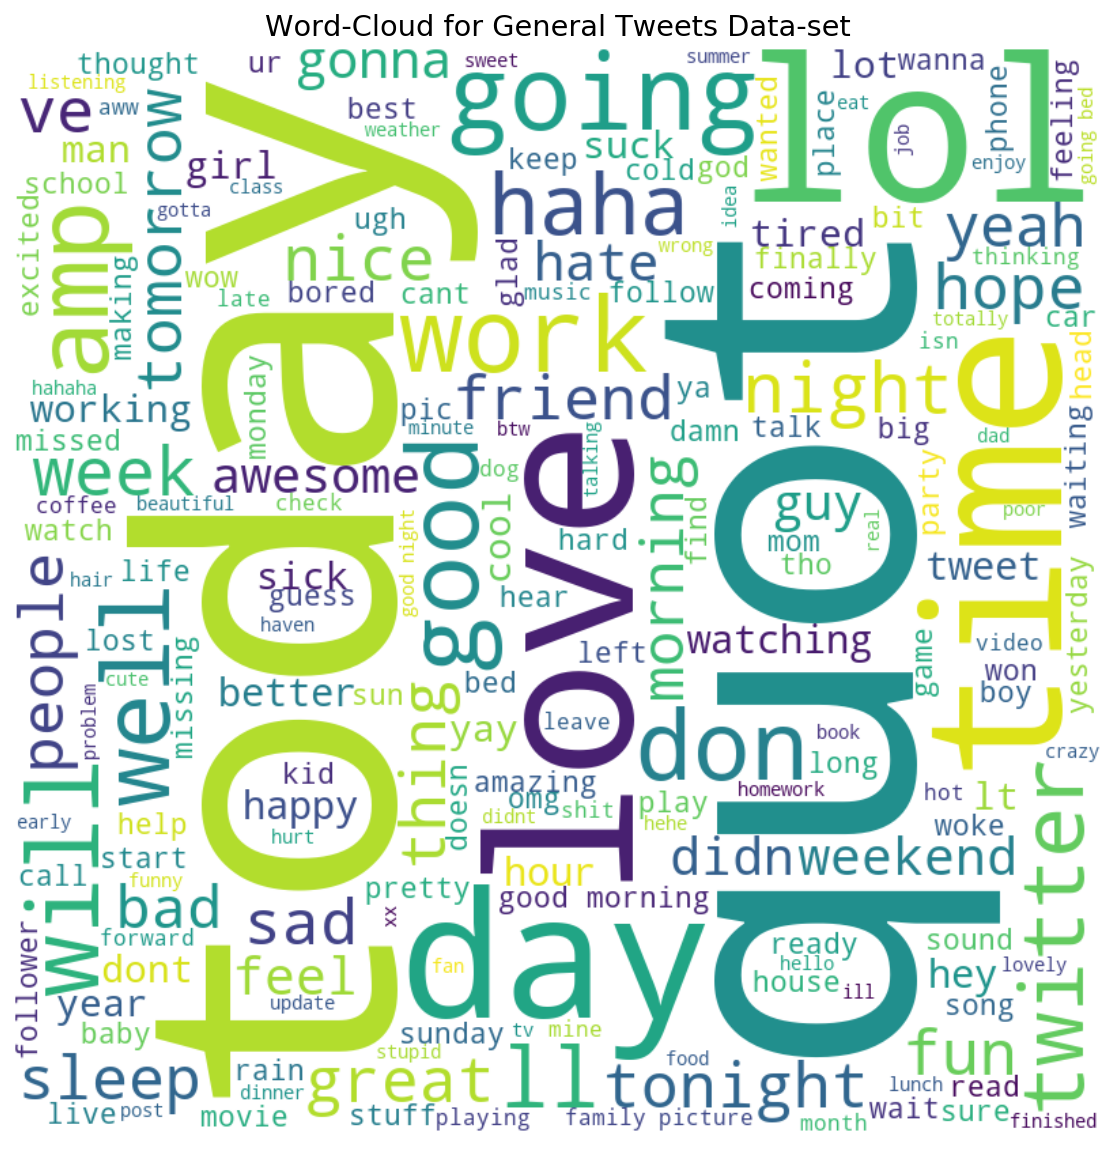

In [10]:
#plot word cloud for generic tweets 

plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(new_string_gen)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word-Cloud for General Tweets Data-set')
plt.show()

We see that in the generic tweets data there are hardly any political words. Most frequent ones are positive words like Love, haha, good & lol.

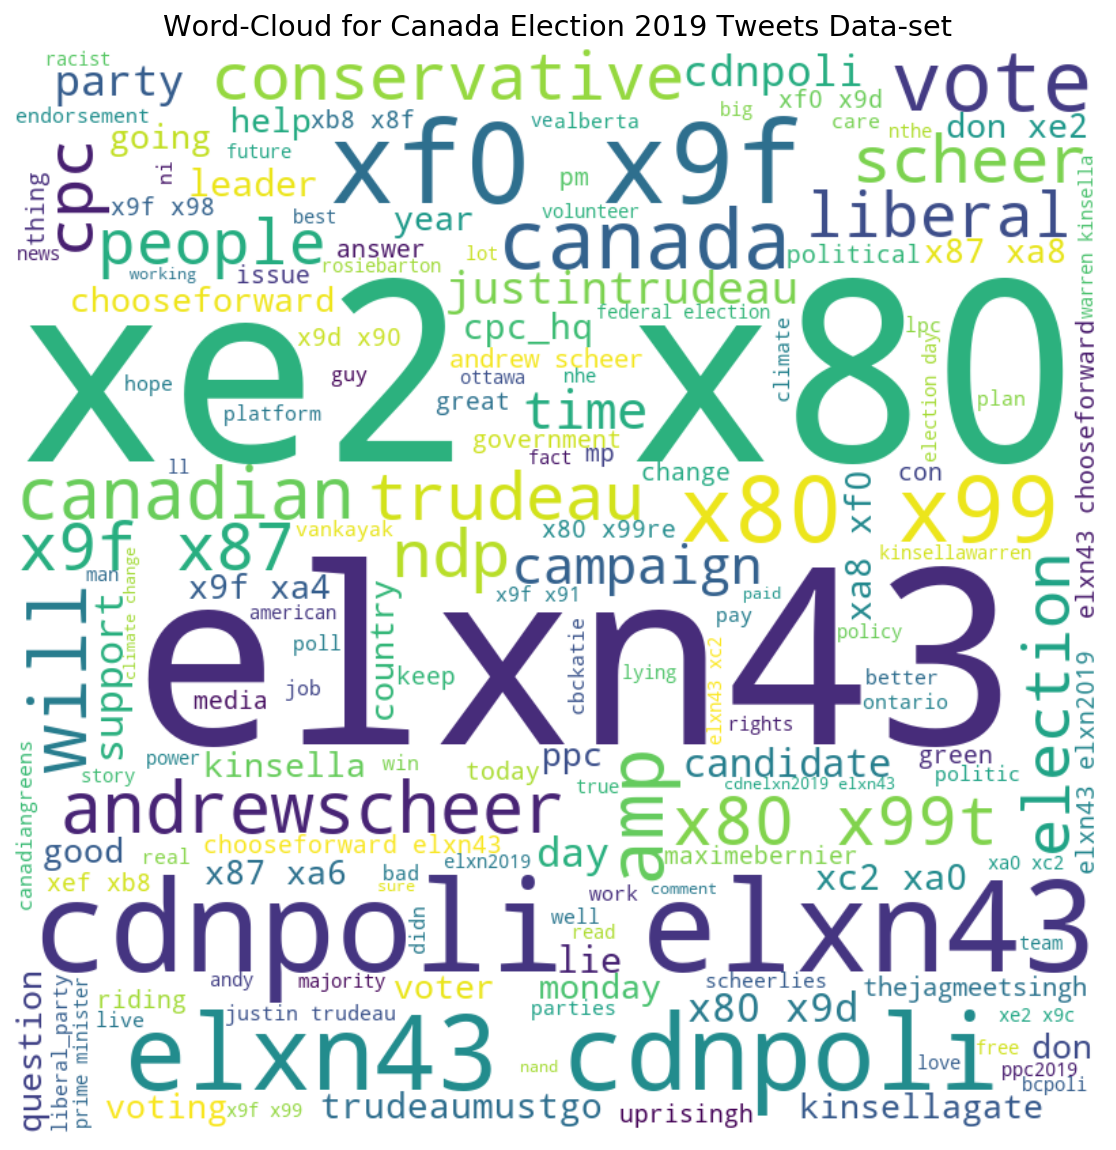

In [11]:
#plot word cloud for Election tweets 
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(new_string_el)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word-Cloud for Canada Election 2019 Tweets Data-set')
plt.show()

For Election dataset, we see that most common words are cdpoli which is hashtag for Canadian Politics. Then we have names of leaders like trudeau, andrewscheer and jagmeetsingh. These are the words we had used while segregating tweets in respective parties.

Now we determine general sentiment of twitter folks towards canadian politics irrespective of party using sentiment count.

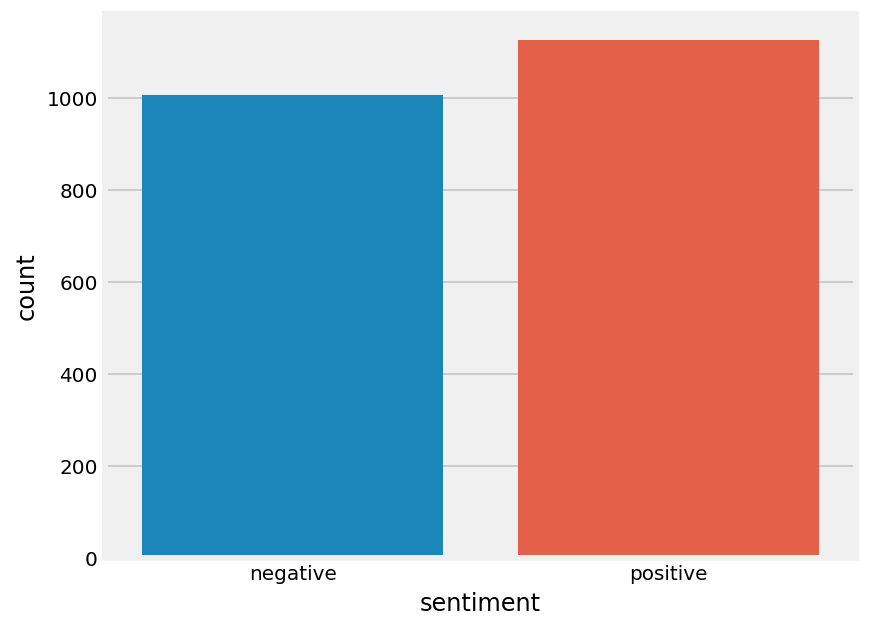

In [12]:
senti_count = df_canada_el['sentiment']
plt.figure(figsize=(6,5))
sns.countplot(x=senti_count,data=df_canada_el)

As we can see positive sentiment has more counts than the negative. Thus we conclude that **people had positive outlook towards canadian politics** irrespective of any party.

The individual party semtiment analysis we will see furthur down in the following sections.

Now we focus on negative tweets & determine what were the majority of the reasons for negative sentiments.
For this we plot countplot of negative reasons. 

[Text(0, 0, 'Women Reproductive right and Racism'),
 Text(0, 0, 'Economy'),
 Text(0, 0, 'Others'),
 Text(0, 0, 'Scandal'),
 Text(0, 0, 'Tell lies'),
 Text(0, 0, 'Privilege'),
 Text(0, 0, 'Climate Problem'),
 Text(0, 0, 'Healthcare'),
 Text(0, 0, 'Separation'),
 Text(0, 0, 'Healthcare and Marijuana')]

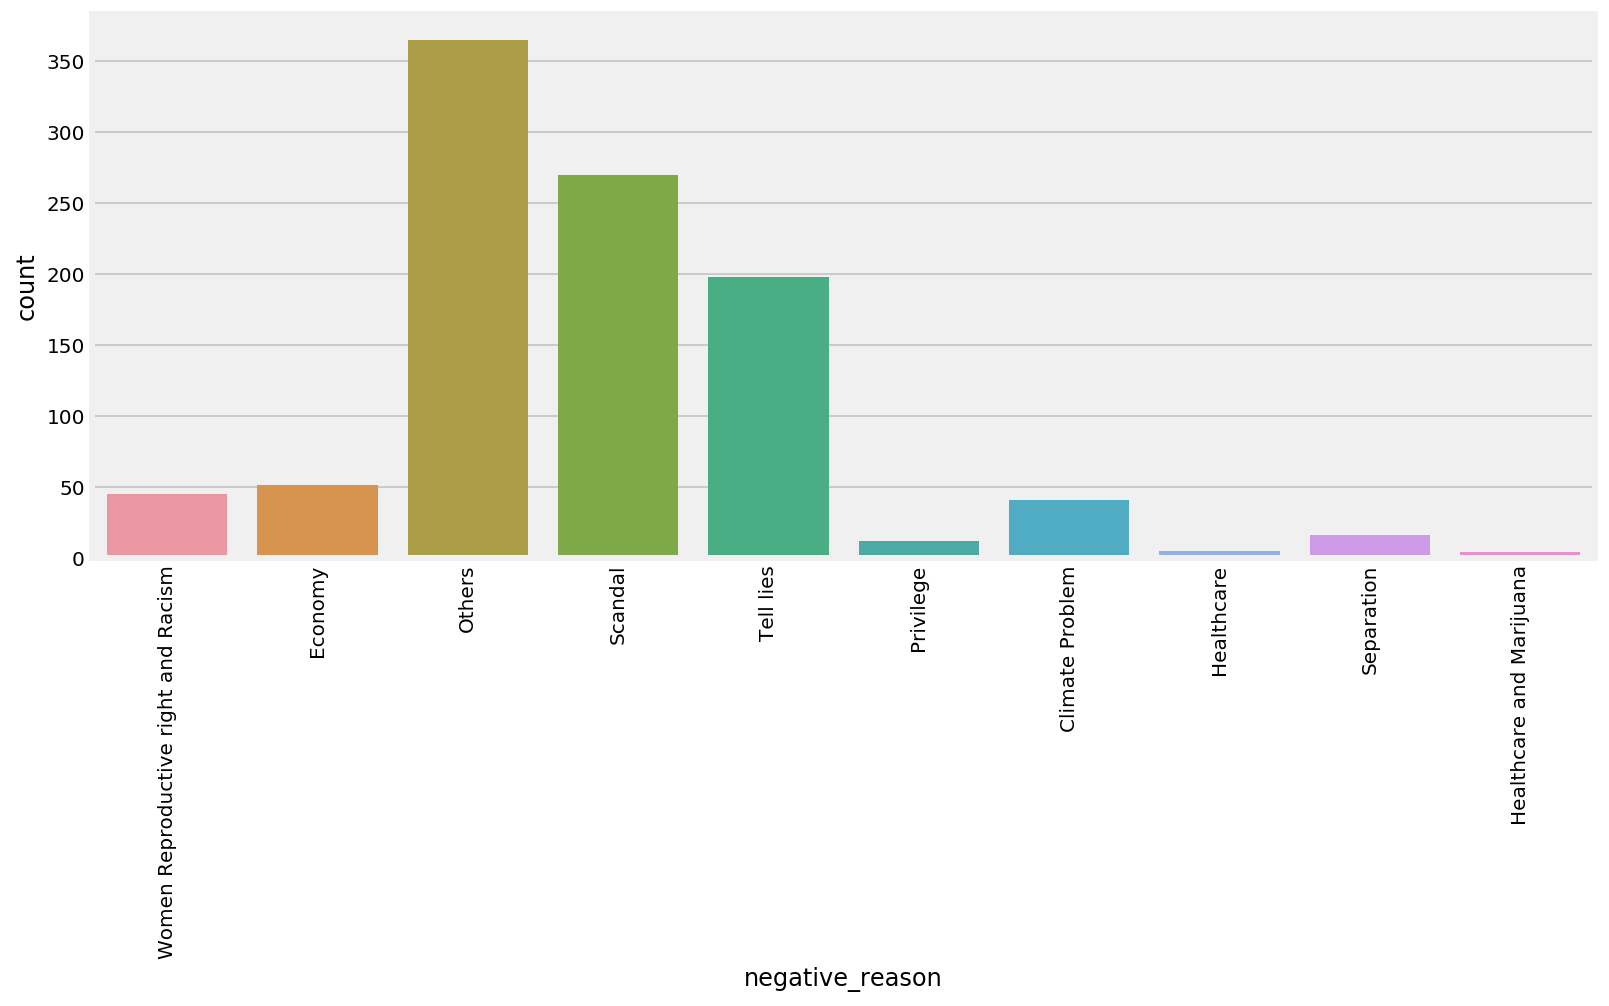

In [13]:
reason_count = df_canada_el['negative_reason']
plt.figure(figsize=(12,5))
chart = sns.countplot(x=reason_count,data=df_canada_el)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

We see that most of the negative reasons doesn't belong to any of the categories listed. From the rest, **top 5** were **Scandal, Tell lies, Economy, Women Reproductive right and Racism & Climate Problem**.  

Now we shift our focus to generic tweets. Here we plot count plot to see distribution of positive & negative sentiments. 

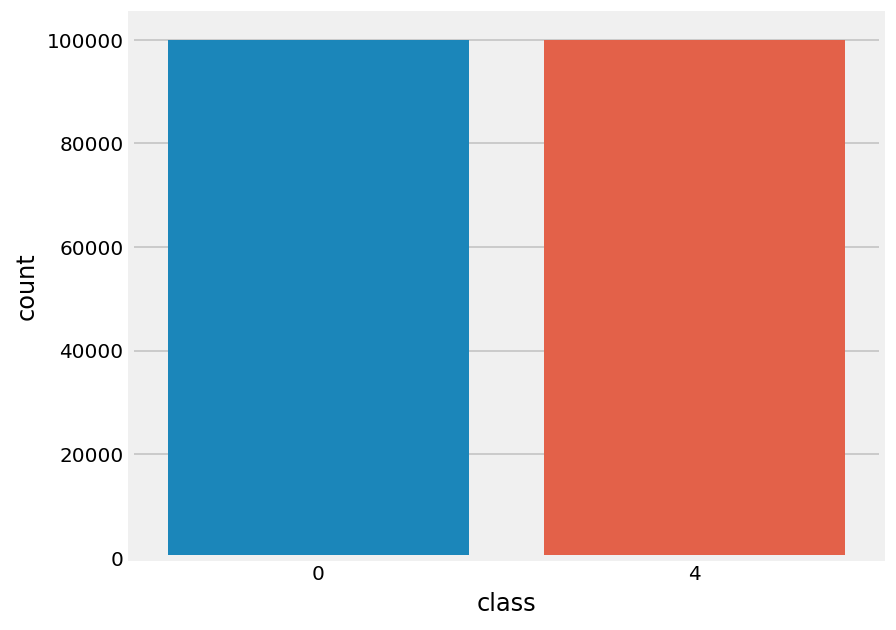

In [14]:
class_count = df_generic_twt['class']
plt.figure(figsize=(6,5))
sns.countplot(x=class_count,data=df_generic_twt)

We see that both positive & negative sentiments have equal counts.

# Model Preparation

Here we start building the best model for the sentiment analysis. Firstly we replace text columns in both generic & election 2019 dataset with clean tweets.

In [15]:
df_canada_el = df_canada_el.assign(text=election_twt_clean,inplace = True)

df_generic_twt  = df_generic_twt.assign(text=generic_twt_clean,inplace = True)

In [16]:
#Show clean dataframe for election 2019
df_canada_el.head()

,sentiment,negative_reason,text,inplace
0,negative,Women Reproductive right and Racism,rosiebarton suggestion agree canadian women tr...,True
1,positive,NaN,allwomanspacewalk real space_station etobicoke...,True
2,negative,Economy,brantford going cost 94 billion 4 years justin...,True
3,positive,NaN,canada canadaelection2019 canadavotes elxn43 n...,True
4,negative,Economy,canada taxpayers sick amp tired hard earned do...,True


Now we encode sentiment column in election 2019 dataframe with its equivalent in generic dataframe i.e. 0 for negative & 4 for positive. This will be helpful in future when we use trained model on generic dataframe to predect sentiments of election tweets.

In [17]:
cleanup_nums = {"sentiment":     {"positive": 4, "negative": 0}}
df_canada_el.replace(cleanup_nums, inplace=True)
df_canada_el.head()

,sentiment,negative_reason,text,inplace
0,0,Women Reproductive right and Racism,rosiebarton suggestion agree canadian women tr...,True
1,4,NaN,allwomanspacewalk real space_station etobicoke...,True
2,0,Economy,brantford going cost 94 billion 4 years justin...,True
3,4,NaN,canada canadaelection2019 canadavotes elxn43 n...,True
4,0,Economy,canada taxpayers sick amp tired hard earned do...,True


In [18]:
#Store 'text' & 'sentiment' from election data
el_fet = df_canada_el['text']
el_clss = df_canada_el['sentiment']

In [19]:
#Store 'text' & 'class' from generic data
gen_fet = df_generic_twt['text']
gen_clss = df_generic_twt['class']

Now we split generic text(features) & sentiments(labels) in train & test set with 70-30% ratio

In [20]:
twt_train, twt_test, clss_train, clss_test = train_test_split(gen_fet, gen_clss, random_state=42, test_size=0.3)

#### Bag of Words

Firstly we will uee Bag of Words approach will all the algorithms as stated above to examine the accuracy of individual algorithm. For this we use CountVectorizer() to convert text body of tweets into respective integer vectors. Also parameters like lowercase, stop_words & tokenizer are not used as we have already performed text lowercasing, tokenizing & removal of stop words.  

In [21]:
# Bag of Words
cv = CountVectorizer()

Here we define function which will take train-test sets for features and labels as well as pipeline for the input. This function performs model fit on train sets, predicts labels & compares it with test set to determine the accuracy. It passes model accuracy, time required for operation & predicted labels.

**Pipeline** - Pipeline is function which sequentially apply a list of transforms and a final estimator. The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.

In [22]:
def acc_summary(pipeline, x_train, y_train, x_test, y_test):
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, train_test_time,y_pred

Firstly we make zip of algorithm names along with respecive function. Zipping makes it easy to pass all the algorithms to fuction in a single go.

In [23]:
names = ["Logistic Regression","Multinomial NB", "Bernoulli NB", "SVM", "Decision Trees", "Random Forest", "XGBoost"]

classifiers = [LogisticRegression(), MultinomialNB(), BernoulliNB(), LinearSVC(), 
               DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier()]

zipped_clf = zip(names,classifiers)

The second function we define takes vectorizer method i.e.Bag of Words or Tf-Idf as well as zip of all algorithms & test-train data. It then selects each model & sends it to acc_summary() along with test-train data for processing. Finally it stores accuracy,time & predictions for all the models & returns them as output. 

In [24]:
def classifier_comparator(vectorizer, classifier, t_train, c_train, t_test, c_test):
    result = []
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        clf_acc,tt_time,pred = acc_summary(checker_pipeline, t_train, c_train, t_test,c_test)
        result.append((n,clf_acc,tt_time,pred))
    return result

Now we use Bag of words approach for all the algorithm and train them on generic tweets dataset. The function will print model name, the default parameter it has used along with accuracy score & train-test time in seconds.

In [25]:
BoW_result = classifier_comparator(cv, zipped_clf, twt_train, clss_train, twt_test, clss_test)

Validation result for Logistic Regression


c:\users\sai\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy score: 74.24%
train and test time: 9.74s
--------------------------------------------------------------------------------
Validation result for Multinomial NB
accuracy score: 73.49%
train and test time: 2.72s
--------------------------------------------------------------------------------
Validation result for Bernoulli NB
accuracy score: 73.54%
train and test time: 2.89s
--------------------------------------------------------------------------------
Validation result for SVM


c:\users\sai\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


accuracy score: 72.55%
train and test time: 46.74s
--------------------------------------------------------------------------------
Validation result for Decision Trees
accuracy score: 67.16%
train and test time: 270.38s
--------------------------------------------------------------------------------
Validation result for Random Forest


c:\users\sai\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy score: 69.64%
train and test time: 265.77s
--------------------------------------------------------------------------------
Validation result for XGBoost
accuracy score: 64.80%
train and test time: 48.53s
--------------------------------------------------------------------------------


#### Tf-Idf

Secondly, we will use Tf-Idf approach the same way we have used Bag of Words method. We will intialize Tf-Idf using TfidfVectorizer(). Here also we use default parametes for the reaons stated above.  

In [26]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer()

In [27]:
#Make Zip of algorithms & functions

names = ["Logistic Regression","Multinomial NB", "Bernoulli NB", "SVM", "Decision Trees", "Random Forest", "XGBoost"]

classifiers = [LogisticRegression(),MultinomialNB(), BernoulliNB(), LinearSVC(), 
               DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier()]

zipped_clf = zip(names,classifiers)

In [28]:
#Pass Tf-Idf to acc_summary
TfIdf_result = classifier_comparator(tfidf_vectorizer, zipped_clf, twt_train, clss_train, twt_test, clss_test)

Validation result for Logistic Regression


c:\users\sai\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy score: 74.62%
train and test time: 4.54s
--------------------------------------------------------------------------------
Validation result for Multinomial NB
accuracy score: 73.09%
train and test time: 3.89s
--------------------------------------------------------------------------------
Validation result for Bernoulli NB
accuracy score: 73.54%
train and test time: 4.70s
--------------------------------------------------------------------------------
Validation result for SVM
accuracy score: 73.48%
train and test time: 5.38s
--------------------------------------------------------------------------------
Validation result for Decision Trees
accuracy score: 67.71%
train and test time: 250.65s
--------------------------------------------------------------------------------
Validation result for Random Forest


c:\users\sai\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy score: 70.49%
train and test time: 196.17s
--------------------------------------------------------------------------------
Validation result for XGBoost
accuracy score: 64.88%
train and test time: 52.66s
--------------------------------------------------------------------------------


Now will make dictionary of algorithm and its accuracy for both Bag of Words and Tf-Idf which we will use to compare accuracies of all algorithms used.

In [29]:
BoW_acc = {}
Tf_Idf_acc = {}

In [30]:
#Summary for Bag of Words
for i in range(len(BoW_result)):
    BoW_acc[BoW_result[i][0]] = BoW_result[i][1]*100
    print('Bag of Words Summary')
    print('algorithm = ',BoW_result[i][0], '\naccuracy =',BoW_result[i][1]*100,'time = ',BoW_result[i][2],'\n')

algorithm =  Logistic Regression 
accuracy = 74.24166666666666 time =  9.735991954803467 

algorithm =  Multinomial NB 
accuracy = 73.49166666666666 time =  2.72298264503479 

algorithm =  Bernoulli NB 
accuracy = 73.53666666666666 time =  2.8897135257720947 

algorithm =  SVM 
accuracy = 72.54666666666667 time =  46.74333357810974 

algorithm =  Decision Trees 
accuracy = 67.15666666666667 time =  270.37530875205994 

algorithm =  Random Forest 
accuracy = 69.63833333333334 time =  265.7710452079773 

algorithm =  XGBoost 
accuracy = 64.79833333333333 time =  48.5257363319397 



In [31]:
#Summary for Tf_Idf
for i in range(len(TfIdf_result)):
    Tf_Idf_acc[TfIdf_result[i][0]] = TfIdf_result[i][1]*100  
    print('Tf-Idf Summary')    
    print('algorithm = ',TfIdf_result[i][0], '\naccuracy =',TfIdf_result[i][1]*100,'time = ',TfIdf_result[i][2],'\n')
    

Tf-Idf
algorithm =  Logistic Regression 
accuracy = 74.61666666666666 time =  4.539181470870972 

Tf-Idf
algorithm =  Multinomial NB 
accuracy = 73.08666666666667 time =  3.892749786376953 

Tf-Idf
algorithm =  Bernoulli NB 
accuracy = 73.53666666666666 time =  4.696312427520752 

Tf-Idf
algorithm =  SVM 
accuracy = 73.48333333333333 time =  5.377918004989624 

Tf-Idf
algorithm =  Decision Trees 
accuracy = 67.71000000000001 time =  250.65069007873535 

Tf-Idf
algorithm =  Random Forest 
accuracy = 70.49333333333333 time =  196.1728391647339 

Tf-Idf
algorithm =  XGBoost 
accuracy = 64.875 time =  52.66189122200012 



Finally we determine which algorithm gives us max. accuracy for both Bag of Words & Tf-Idf.

In [32]:
max_acc_BoW = max(BoW_acc, key=BoW_acc.get)
max_acc_TfIdf = max(Tf_Idf_acc, key=Tf_Idf_acc.get)
print('Bag of Words = ',max_acc_BoW,'Accuracy = ', BoW_acc[max_acc_BoW])
print('=======================================================')
print('Tf-Idf = ',max_acc_TfIdf,'Accuracy = ', Tf_Idf_acc[max_acc_TfIdf])

Bag of Words =  Logistic Regression Accuracy =  74.24166666666666
Tf-Idf =  Logistic Regression Accuracy =  74.61666666666666


We see that for both the Bag of Words & Tf-Idf methods we got max. of around 74% accuracy with Logistic Regression. We also see that Tf-Idf approach give us slightly better accuracy of 74.62% as compared to Bag of Words (74.24%)

Now we will use Tf-Idf with Logistic Regression on the election data with election text and labels as test set.

In [33]:
#Zip logistic regression
name = ["Logistic Regression"]

classifier = [LogisticRegression()]

zipped_clf = zip(name,classifier)

In [34]:
#Use Tf-Idf with zip and pass it with election data as test data

TfIdf_el_result = classifier_comparator(tfidf_vectorizer, zipped_clf, twt_train, clss_train, el_fet, el_clss)

Validation result for Logistic Regression


c:\users\sai\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy score: 60.24%
train and test time: 4.09s
--------------------------------------------------------------------------------


We see that the model that we got from generic tweet data i.e. Logistic Regression with **Tf-Idf** gave us **60.24%** 

Now we will visualize our output. For this we will firstly extract our predictions & add it to our elections dataframe

In [35]:
el_senti_pred = TfIdf_el_result[0][3]

In [36]:
df_canada_el['pred_senti'] = el_senti_pred
df_canada_el

,sentiment,negative_reason,text,inplace,pred_senti
0,0,Women Reproductive right and Racism,rosiebarton suggestion agree canadian women tr...,True,4
1,4,NaN,allwomanspacewalk real space_station etobicoke...,True,4
2,0,Economy,brantford going cost 94 billion 4 years justin...,True,0
3,4,NaN,canada canadaelection2019 canadavotes elxn43 n...,True,0
4,0,Economy,canada taxpayers sick amp tired hard earned do...,True,0
...,...,...,...,...,...
2128,0,Scandal,good job smearing campaign andrewscheer cdnpol...,True,4
2129,0,Scandal,missed comment deflecting issue answer best re...,True,0
2130,4,NaN,daily reminder thejagmeetsingh endorses strate...,True,4
2131,0,Women Reproductive right and Racism,yup going reopen abortion debate xf0 x9f x98 x...,True,4


We define **get_senti()** function which take tweets for each political party from election 2019 dataset which we had gotten from political_party() function & determine positive & negative tweet count for both actual & predicted column. Thus for each political party we get 4 outputs:
1. Acutal positive count 
2. Actual negative count 
3. Predicted positive count 
4. Predicted negative count. 

In [37]:
def get_senti(party):
    senti = []
    pred_senti = []

    #iterate over each tweet to determine its sentiment
    for i in party:
        a = df_canada_el.loc[df_canada_el['text'] == i, 'sentiment'].iloc[0]
        b = df_canada_el.loc[df_canada_el['text'] == i, 'pred_senti'].iloc[0]
        #append it in proper array
        senti.append(a)
        pred_senti.append(b)
    #get actual & predicted count
    pos_senti = senti.count(4)
    neg_senti = senti.count(0)
    pos_pred = pred_senti.count(4)
    neg_pred = pred_senti.count(0) 
    return pos_senti,pos_pred,neg_senti,neg_pred

#get all 4 counts for each party
Lib_pos, Lib_pred_pos, Lib_neg, Lib_pred_neg = get_senti(Liberal_el) 
Con_pos, Con_pred_pos,Con_neg, Con_pred_neg  = get_senti(Conservative_el)
NDP_pos, NDP_pred_pos, NDP_neg, NDP_pred_neg = get_senti(NDP_el)
NONE_pos, NONE_pred_pos, NONE_neg, NONE_pred_neg = get_senti(NONE_el)

Now we will plot acutal vs predicted positive & negative count for all 4 political parties. We will use barchart for this

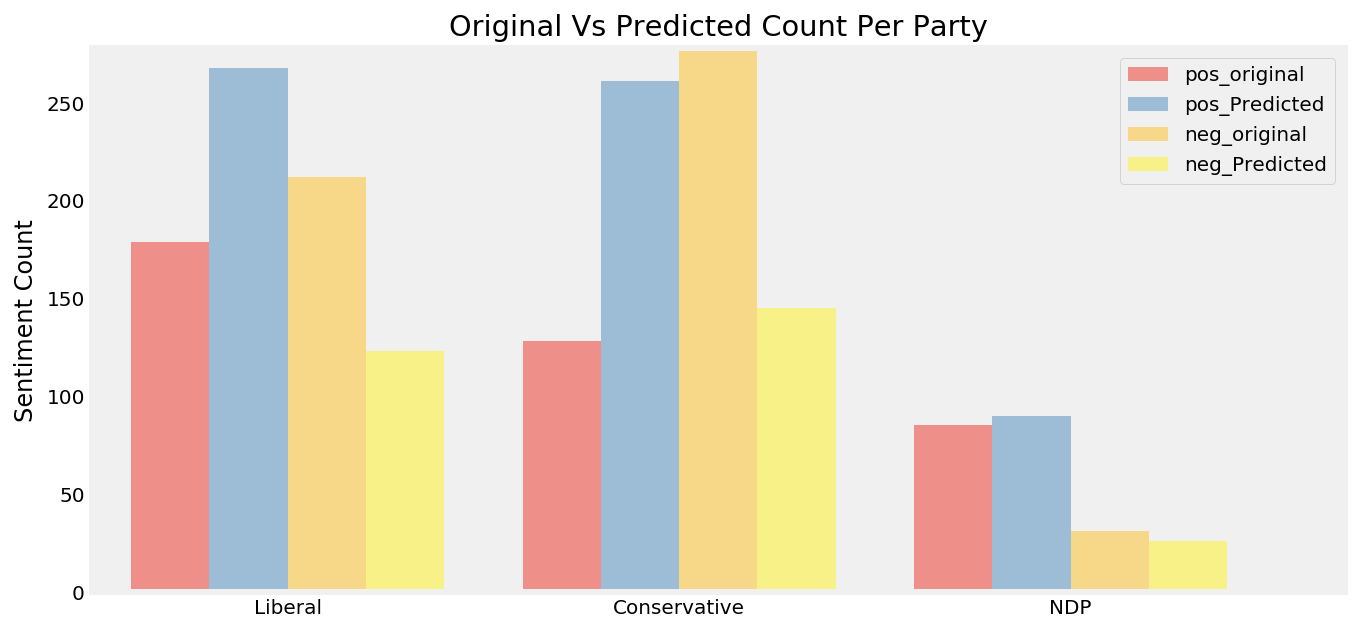

In [39]:

senti_positive = (Lib_pos, Con_pos, NDP_pos)
senti_positive_pred = (Lib_pred_pos, Con_pred_pos, NDP_pred_pos)

senti_negative = (Lib_neg, Con_neg, NDP_neg)
senti_negative_pred = (Lib_pred_neg, Con_pred_neg, NDP_pred_neg)

# Setting the positions and width for the bars
pos = list(range(3)) 
width = 0.20 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))


plt.bar(pos, senti_positive, width, alpha=0.5, color='#EE3224', label='pos_original') 

plt.bar([p + width for p in pos], senti_positive_pred, width, alpha=0.5, color='#4B8BBE',label='Pos_Predicted') 

plt.bar([p + width*2 for p in pos], senti_negative, width, alpha=0.5, color='#FFC222', label='neg_original') 

plt.bar([p + width*3 for p in pos], senti_negative_pred, width, alpha=0.5, color='#FFF222', label='neg_Predicted') 

# Set the y axis label
ax.set_ylabel('Sentiment Count')

# Set the chart's title
ax.set_title('Original Vs Predicted Count Per Party')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(['Liberal', 'Conservative', 'NDP'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*5)
plt.ylim([0, max(senti_positive + senti_positive_pred + senti_negative + senti_negative_pred)] )

# Adding the legend and showing the plot
plt.legend([ 'pos_original','pos_Predicted', 'neg_original','neg_Predicted'], loc='upper right')
plt.grid()
plt.show()

We see that our model had **most accurate predictions for NDP**. For Liberal & Conservative parties we have close predicitons for Liberal Party as compared to Conservative party. 

#### Multi-class Classification Models

Now we will separate out our negative sentiments from election dataframe to build Multi-class Classification Models to predict the reason for the negative tweets.

In [40]:
df_el_neg = df_canada_el[df_canada_el['sentiment']== 0]

Here our target variable is negative reasons which are in text form & for analysis we want it in numerical form. For purpose we will encode them using LabelEncoder. We could have used same replace strategy as we had use earlier but in that case there were only 2 variables positive & negative Thus it was easy. Here we have 9 variables. If we use replace method, it would be lengthy & not compact. therefore we will go ahead with LabelEncoder

In [42]:
lb_make = LabelEncoder()
col = ['sentiment','text', 'negative_reason']
df_el_neg = df_el_neg[col]
df_el_neg = df_el_neg[pd.notnull(df_el_neg['negative_reason'])]

df_el_neg['neg_id'] = lb_make.fit_transform(df_el_neg['negative_reason'])

df_el_neg.head()

,sentiment,text,negative_reason,neg_id
0,0,rosiebarton suggestion agree canadian women tr...,Women Reproductive right and Racism,9
2,0,brantford going cost 94 billion 4 years justin...,Economy,1
4,0,canada taxpayers sick amp tired hard earned do...,Economy,1
5,0,canadavotes2019 elxn43 cdnpoli facts blastfrom...,Others,4
8,0,chooseforward cdnpoli elxn43 ncanada don ameri...,Others,4


Now we will make some data structures which would be helpful for us to visualize the data. 
Firstly we make dataframe of unique reasons along with its encoded id. Secodly we make dictionary of reason with its encoded id. This dictionay will be helpful when we peroform correlation to visualize the confusion matrix & fetch the data from the dataframe.

In [43]:
neg_id_df = df_el_neg[['negative_reason', 'neg_id']].drop_duplicates().sort_values('neg_id')
category_to_id = dict(neg_id_df.values)
id_to_category = dict(neg_id_df[['neg_id', 'negative_reason']].values)

Now we split the data into train-test in 70-30% ratio as stated in assignment.

In [44]:
neg_train, neg_test, rson_train, rson_test, indices_train, indices_test  = train_test_split(df_el_neg['text'], df_el_neg['neg_id'],df_el_neg.index, random_state=1, test_size=0.3)

Here we chose Logistic Regression as it gave the best result in our previous analysis. We chose Multinomial Naive Bayes as it gave second best accuracy & Random Forest as it gave 3rd best. We chose Tf-Idf for the similar reason.

In [45]:
#Zip functions
names = ["Logistic Regression","Multinomial NB","Random Forest"]

classifiers = [LogisticRegression(), MultinomialNB(),RandomForestClassifier()]

zipped_clf = zip(names,classifiers)

In [46]:
#Pass to acc_summary
neg_result = classifier_comparator(tfidf_vectorizer, zipped_clf, neg_train, rson_train, neg_test, rson_test)

Validation result for Logistic Regression
accuracy score: 49.01%
train and test time: 0.12s
--------------------------------------------------------------------------------
Validation result for Multinomial NB
accuracy score: 46.03%

c:\users\sai\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sai\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\sai\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



train and test time: 0.08s
--------------------------------------------------------------------------------
Validation result for Random Forest
accuracy score: 48.68%
train and test time: 0.14s
--------------------------------------------------------------------------------


We see that out of the 3 algorithms we got the best results for the Random Forest algorithm.

# Model Accuracy Comparisons - Analysis & Visualization

Firstly we will make new dataframe for actual test data & predicted results.

In [47]:
data = {'result':neg_result[2][3],'actual':rson_test}
df_data = pd.DataFrame(data) 

Now we will continue with our best model (Random Forest) and are going to look at the confusion matrix, and show the discrepancies between predicted and actual labels.

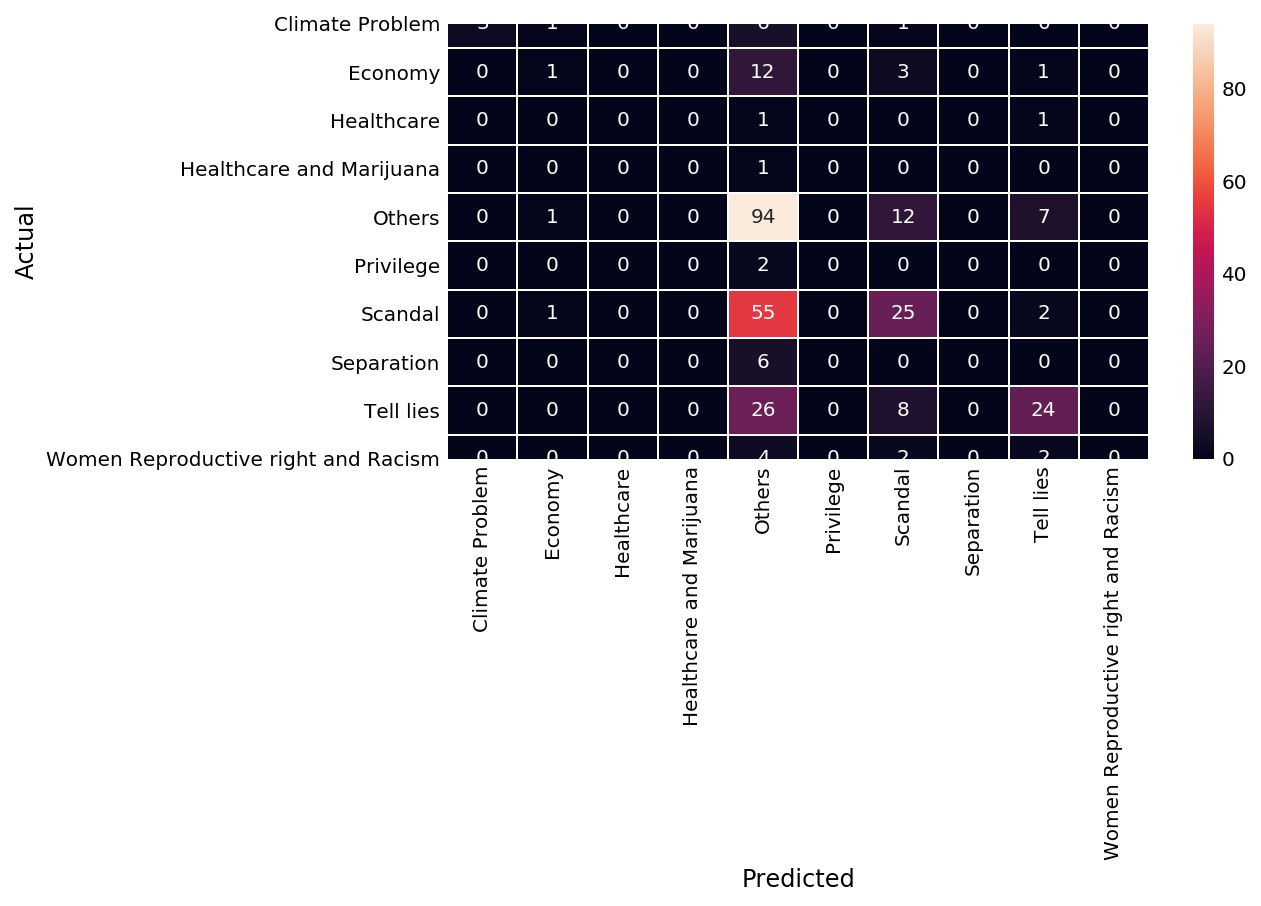

In [48]:
conf_mat = confusion_matrix(df_data['actual'], df_data['result'])
fig, ax = plt.subplots(figsize=(7, 4))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=neg_id_df.negative_reason.values, yticklabels=neg_id_df.negative_reason.values,linewidths=.5, ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

We see that the **vast majority of the predictions end up on the diagonal (predicted label = actual label)**, where we want them to be.These are the number of predictions that our model has predicted correctly. However, there are a number of misclassifications, these are the predictions/numbers which are not on the diagonal.

Now we will see what those are caused by:

Now we will use the data structures we had created earlier, the dictionaries & data-frame of negative_reasons & its encoded equivalent. We will iterate over each element from the confusion matrix & if that element is not on the diagonal, we will fetch the tweets that belong to that reason & try to see why it may have misqualified.  

In [49]:
for predicted in neg_id_df.neg_id: 
    for actual in neg_id_df.neg_id:
        if((predicted != actual) and (conf_mat[actual, predicted] >= 10)): 
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))

'Economy' predicted as 'Others' : 12 examples.
'Scandal' predicted as 'Others' : 55 examples.
'Tell lies' predicted as 'Others' : 26 examples.
'Others' predicted as 'Scandal' : 12 examples.


We see that all of the tweets got misclasssified as others and vice-versa. **This means that there is possibility that the 'Other' category may have similar words/phrases that are also present in the categories like 'Economy','Scandal' & 'Tell lies'**. Thus one possible solution might be dissolve 'Other' category tweets randomly into all 8 categories and then do analysis again.

# HyperParameter Tuning

We got the **best accuracy using Random Forest with Tf-Idf**. But the model that we used took default parameters while training the data. Thus we can increase the accuracy of the model by tuning the right parameters. For this we will now perform the hyperparameter tuning.

The most important hyperparameter for the Random Forest are, number of decision trees in the forest as well as features to be considered while splitting the node.
In our case we will consider following paramters as they largely impact the performace of the model & thus accuarcy:

* n_estimators = number of trees in the foreset

* max_features = max number of features considered for splitting a node

* max_depth = max number of levels in each decision tree

* min_samples_split = min number of data points placed in a node before the node is split

* min_samples_leaf = min number of data points allowed in a leaf node

* bootstrap = method for sampling data points (with or without replacement)

We only have vague idea of the best hyperparameters and therefore to narrow our search down we will evaluate a wide range of values for each hyperparameter. 
Using Scikit-Learn’s **RandomizedSearchCV method**, we can define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values.

**The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try**, and cv which is the number of folds to use for cross validation (we use 100 and 3 respectively). **More iterations will cover a wider search space and more cv folds reduces the chances of overfitting**, but raising each will increase the run time.

In [50]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

a = neg_train
rf = RandomForestClassifier()
vectorizer = TfidfVectorizer()
vectorizer.fit(a)
X = vectorizer.transform(a)

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, rson_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 13.0min finished
c:\users\sai\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

Now we will view the best parameters from fitting the random search:

In [51]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': False}

Now we will determine if random search yielded a better model by comparing the base model with the best random search model. For this we will use new set of hyperparameter instead of default parameters.

In [52]:
names = ["Random Forest Best"]

classifiers = [rf_random.best_estimator_]

zipped_clf = zip(names,classifiers)

In [53]:
best_result = classifier_comparator(tfidf_vectorizer, zipped_clf, neg_train, rson_train, neg_test, rson_test)

Validation result for Random Forest Best
accuracy score: 54.30%
train and test time: 6.88s
--------------------------------------------------------------------------------


In [54]:
print('Improvement of {:0.2f}%.'.format( 100 * (best_result[0][1]*100 - neg_result[2][1]*100) / (neg_result[2][1]*100)))

Improvement of 11.56%.


**We see that we have increase in the model accuracy with new set of hyperparameters**.

Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with **GridSearchCV**, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, **we make another grid based on the best values provided by random search**.

In [55]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [55, 60, 65],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [2000, 3000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


In [56]:
grid_search.fit(X, rson_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 22.6min finished
c:\users\sai\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [57]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 3000}

Finally we will see if the hyperparameters give us furthur good result or we have maxed our performace limit. We will use hyperparameters given by GridSearch.

In [58]:
names = ["Random Forest Best"]

classifiers = [grid_search.best_estimator_]

zipped_clf = zip(names,classifiers)

In [59]:
best_result = classifier_comparator(tfidf_vectorizer, zipped_clf, neg_train, rson_train, neg_test, rson_test)

Validation result for Random Forest Best
accuracy score: 52.98%
train and test time: 12.97s
--------------------------------------------------------------------------------


**Thus we see that we have maxed our model performace with this new set of hyperparameters. Thus we can conclude that we got maximum accuracy of nearly 55% using Random Forest with Tf-Idf with hyperparameter given by RandomSearch**.

# Results & Conclusion 

Based on the  models we had developed following results were drawn:

1] The best model we got was Logistic Regression with Tf-Idf which gave us around 60% accuracy on election dataset. From plotting the results for individual party it was observed that the model gave most accurate result for NDP party which had the mostly the positive sentiments. While model had discripancy for the Conservative & Liberal parties in terms of actual & predicted numbers, the results from the predictions matched with the result of election. From the comparison plot it can observed that NDP party had the lowest tweet count amongst all 3 though its ratio of positive to negative was highest. For Liberal party, its ratio of positive to negative is far better than Conservative. Thus our model makes true prediction about the peoples semtiments of political parties. 

2] From above results we can conclude NLP analytics based on tweets is useful for political parties during election campaigns.

3] “What can public opinion on Twitter tell us about the Canadian political landscape in 2019?” 
Answer - From our model we can tell that people had mostly positive outlook towards Canadian Politics. This is because number of tweets with positive sentiments is more than tweets with negative sentiments. Secondly, we can say that NDP is the party which is less popular but is good in public eyes. It can be confirmed from the comparison chart for all 3 parties. Thirdly, We can conclude that Justin Tredeau is more populare than Andrew Scheer & Jagmeet Singh. This we can confirm from wordcloud.

4] In case of 2nd model we see that all of the tweets got misclasssified as others and vice-versa. This means that there is possibility that the 'Other' category may have similar words/phrases that are also present in the categories like 'Economy','Scandal' & 'Tell lies'. Thus one possible solution might be dissolve 'Other' category tweets randomly into all 8 categories and then do analysis again.

5] Here only did Hyperparameter Tuning for 2nd model. We can improve performace of 1st model using Hyperparameter Tuning. For the 2nd model we can use Word Embeddings to imorove the NLP performance.